In [1]:
# imports

# python packages
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.font_manager
import rpy2
from functools import reduce

# rpy2 imports
from rpy2 import robjects as ro
from rpy2.robjects.packages import importr
from rpy2.ipython.ggplot import image_png

# load rpy2 extension for ipython
%load_ext rpy2.ipython

# stop showing SettingWithCopyWarning
pd.options.mode.chained_assignment = None


/Users/blasks/Library/Caches/pypoetry/virtualenvs/stromatolite-paper-AG5eZpWO-py3.10/lib/python3.10/site-packages/rpy2/robjects/lib/ggplot2.py:70: UserWarning: This was designed againt ggplot2 versions starting with 3.3. but you have 3.4.1
  warnings.warn(


In [14]:
# install & import r package sctransform

# check if sctransform is installed
if not ro.packages.isinstalled('sctransform'):
    # select CRAN mirror
    utils = importr('utils')
    utils.chooseCRANmirror(ind=1)
    # install sctransform
    utils.install_packages(ro.vectors.StrVector(['sctransform']))
    
# check if glmGamPoi is installed
if not ro.packages.isinstalled('glmGamPoi'):
    print('Please install glmGamPoi: https://github.com/const-ae/glmGamPoi')

# import sctransform
sctransform = importr('sctransform')
rmatrix = importr('Matrix')

# should be version 0.3.5 or higher                           
print(sctransform.__version__)


0.3.5


In [3]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#FFB1CA', '#63B9FF', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300
    

In [17]:
# helper functions

# function to calculate 0-sensitive geometric mean
def geometric_mean(vector, pseudocount=1):
    return np.exp(np.mean(np.log(vector + pseudocount))) - pseudocount

# function to convert pandas dataframe to r matrix
def pandas_dataframe_to_r_matrix(df, dtype=float):
    """
    Function to convert pandas DataFrame objects to R matrix objects.
    """
    if dtype is float:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    elif dtype is str:
        vector = ro.vectors.StrVector(df.values.flatten().tolist())
    elif dtype is int:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    else:
        raise ValueError('The dtype {} is not recognized'.format(dtype))
    matrix = rmatrix.Matrix(
        data=vector, 
        nrow=df.shape[0], 
        ncol=df.shape[1], 
        byrow=True, 
        dimnames=[df.index.to_list(), df.columns.to_list()], 
        sparse=True
    )
    return matrix


In [16]:
rmatrix.Matrix()

<rpy2.robjects.methods.RS4 object at 0x542fc4a80> [RTYPES.S4SXP]
R classes: ('ldiMatrix',)

# Read in collated mapping counts and metadata

In [5]:
# read in metadata

# filepaths
filepath_genome_metadata = '../../data/metadata/genome_metadata.csv'
filepath_ortholog_metadata = '../../data/metadata/ortholog_metadata.csv'
filepath_sample_metadata = '../../data/metadata/sample_metadata.csv'

# genome metadata
genome_df = pd.read_csv(filepath_genome_metadata)

#  ortholog metadata
ortholog_df = pd.read_csv(filepath_ortholog_metadata)

#  sample metadata
sample_df = pd.read_csv(filepath_sample_metadata)
sample_df['Cruise'] = sample_df['Cruise'].map({'kok1606': 'G1', 
                                               'mgl1704': 'G2', 
                                               'km1906': 'G3'})

# create annotations_df to map annotations back to orthologs
annotations_df = ortholog_df[['OrthologID', 'Annotation']].drop_duplicates()

sample_df


,SampleID,Cruise,Dataset,Experiment,Station,Cast,Datetime,Latitude,Longitude,Depth,Replicate,SmallFraction,LargeFraction,Unfractionated
0,G3.DEPTH.NS.S6C7.130m.B,G3,Gradients 3 depth profile,NaN,6.0,7.0,4/22/19 6:36,32.92,-158.0,130.0,B,G3.DEPTH.NS.S6C7.130m.0_2um.B,NaN,True
1,G3.DEPTH.NS.S6C7.75m.A,G3,Gradients 3 depth profile,NaN,6.0,7.0,4/22/19 6:40,32.92,-158.0,75.0,A,G3.DEPTH.NS.S6C7.75m.0_2um.A,NaN,True
2,G3.DEPTH.NS.S6C7.75m.B,G3,Gradients 3 depth profile,NaN,6.0,7.0,4/22/19 6:40,32.92,-158.0,75.0,B,G3.DEPTH.NS.S6C7.75m.0_2um.B,NaN,True
3,G3.DEPTH.NS.S6C7.15m.A,G3,Gradients 3 depth profile,NaN,6.0,7.0,4/22/19 6:44,32.92,-158.0,15.0,A,G3.DEPTH.NS.S6C7.15m.0_2um.A,NaN,True
4,G3.DEPTH.NS.S6C7.15m.B,G3,Gradients 3 depth profile,NaN,6.0,7.0,4/22/19 6:44,32.92,-158.0,15.0,B,G3.DEPTH.NS.S6C7.15m.0_2um.B,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,G2.REXP3.NS.LoNP.T96.A,G2,Resource ratio incubation,REXP3 T96 LoNP A,NaN,NaN,6/12/17,NaN,NaN,NaN,A,G2.REXP3.NS.LoNP.T96.0_2um.A,G2.REXP3.NS.LoNP.T96.3um.A,False
218,G2.REXP3.NS.LoNP.T96.C,G2,Resource ratio incubation,REXP3 T96 LoNP C,NaN,NaN,6/12/17,NaN,NaN,NaN,C,G2.REXP3.NS.LoNP.T96.0_2um.C,G2.REXP3.NS.LoNP.T96.3um.C,False
219,G2.REXP3.NS.NPFe.T96.A,G2,Resource ratio incubation,REXP3 T96 NPFe A,NaN,NaN,6/12/17,NaN,NaN,NaN,A,G2.REXP3.NS.NPFe.T96.0_2um.A,G2.REXP3.NS.NPFe.T96.3um.A,False
220,G2.REXP3.NS.NPFe.T96.B,G2,Resource ratio incubation,REXP3 T96 NPFe B,NaN,NaN,6/12/17,NaN,NaN,NaN,B,G2.REXP3.NS.NPFe.T96.0_2um.B,G2.REXP3.NS.NPFe.T96.3um.B,False


In [6]:
# read in mapped transcript abundance data

filepath_data = '../../data/2-mapping/collated_salmon_data.csv.gz'
mappings_df = pd.read_csv(filepath_data)
mappings_df


,MappingName,GeneLength,TPM,NumReads,SampleID,GenomeName,GeneID
0,AG-311-D23_2717613068,360,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613068
1,AG-311-D23_2717613069,114,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613069
2,AG-311-D23_2717613070,1083,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613070
3,AG-311-D23_2717613071,1053,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613071
4,AG-311-D23_2717613072,1080,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613072
...,...,...,...,...,...,...,...
216275059,W9_2553539569,447,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539569
216275060,W9_2553539570,249,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539570
216275061,W9_2553539571,324,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539571
216275062,W9_2553539572,483,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539572


# Process mapped reads

- Drop reference genes without ortholog mapping (hypothesized to mostly be rRNA & other highly conserved RNA)
- Within each clade in each sample, aggregate reads mapping to the same ortholog


In [7]:
# collect reads mapping to known orthologs only and aggregate within orthologs

pangenome_df = mappings_df[['MappingName', 'SampleID', 'GenomeName', 'NumReads', 'GeneLength']]

# add genus, clade, and ortholog info to dataframe
pangenome_df['Genus'] = pangenome_df['GenomeName'].map(genome_df.set_index('GenomeName')['Genus'])
pangenome_df['Clade'] = pangenome_df['GenomeName'].map(genome_df.set_index('GenomeName')['Clade'])
pangenome_df['OrthologID'] = pangenome_df['MappingName'].map(ortholog_df.set_index('MappingName')['OrthologID'])

# down-select to only the genes with an ortholog mapping
pangenome_df = pangenome_df[~pangenome_df['OrthologID'].isna()]

# aggregate all orthologs in same genus
pangenome_df = pangenome_df.groupby(['SampleID', 'Genus', 'Clade', 
                                  'OrthologID']).agg(Reads=('NumReads', 'sum')).reset_index()

# identify nonzero mappings (at least one read mapped to ortholog-sample-clade)
pangenome_df['Nonzero'] = pangenome_df['Reads'].gt(0.0)

pangenome_df


,SampleID,Genus,Clade,OrthologID,Reads,Nonzero
0,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000001.0,79.000,True
1,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000002.0,64.000,True
2,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000003.0,18.000,True
3,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000004.0,1583.802,True
4,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000005.0,814.674,True
...,...,...,...,...,...,...
21847903,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040282.0,0.000,False
21847904,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040288.0,0.000,False
21847905,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040290.0,0.000,False
21847906,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040293.0,0.000,False


# Normalize data using sctransform

* Normalize each clade separately

In [20]:
# separate out data for most highly represented clades in dataset

# thresholds
detection_min = 3
coverage_threshold = 0.01
clades = ['HLI', 'HLII', 'LLI', '5.1A-I', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1B-VII', 'CDR2']

# storage variables
ortho_list = []
sample_list = []
core_df_list = []

for selected_clade in clades:
    print(selected_clade)
    clade_pangenome_df = pangenome_df[pangenome_df.Clade == selected_clade]

    # down-select data to detected orthologs
    core_df = pd.DataFrame(clade_pangenome_df.groupby('OrthologID').Nonzero.sum())
    core_df = core_df[core_df.Nonzero.gt(0)]
#     core_df = core_df[core_df.Nonzero.ge(detection_min)]
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df.OrthologID.isin(core_df.index)]

    # down-select to only samples with coverage that is at least x% of the max coverage found in the dataset
    coverage = clade_pangenome_df.groupby('SampleID').Nonzero.sum()
    max_cov = coverage.max()
    total_orthos = len(core_df.index)
    print('Max coverage: {} / {} orthologs ({})'.format(max_cov, total_orthos, max_cov/total_orthos))
    samples = coverage[coverage.gt(coverage.max() * coverage_threshold)].index
    sample_list.append(samples)
    min_cov = coverage[samples].min()
    print('Min coverage: {} / {} orthologs ({})'.format(min_cov, total_orthos, min_cov/total_orthos))
    print('Total samples: {}\n'.format(len(samples)))
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df['SampleID'].isin(samples)]
    
    # down-select data to only orthologs that show up in a minimum number of the remaining samples
    core_df = pd.DataFrame(clade_pangenome_df.groupby('OrthologID').Nonzero.sum())
    core_df = core_df[core_df.Nonzero.ge(detection_min)]
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df.OrthologID.isin(core_df.index)]
    ortho_list.append(core_df.index)

    # pivot table
    clade_core_df = clade_pangenome_df.pivot(index='OrthologID', columns=['SampleID'], values='Reads')
    core_df_list.append(clade_core_df)
    

HLI
Max coverage: 2798 / 3843 orthologs (0.7280770231589904)
Min coverage: 28 / 3843 orthologs (0.007285974499089253)
Total samples: 175

HLII
Max coverage: 3418 / 4772 orthologs (0.7162615255658005)
Min coverage: 39 / 4772 orthologs (0.008172673931265717)
Total samples: 137

LLI
Max coverage: 3123 / 3587 orthologs (0.870643992194034)
Min coverage: 34 / 3587 orthologs (0.009478672985781991)
Total samples: 129

5.1A-I
Max coverage: 2569 / 3316 orthologs (0.7747285886610374)
Min coverage: 28 / 3316 orthologs (0.008443908323281062)
Total samples: 202

5.1A-II
Max coverage: 2940 / 3361 orthologs (0.8747396608152336)
Min coverage: 33 / 3361 orthologs (0.009818506396905683)
Total samples: 130

5.1A-III
Max coverage: 1881 / 2412 orthologs (0.7798507462686567)
Min coverage: 19 / 2412 orthologs (0.007877280265339967)
Total samples: 123

5.1A-IV
Max coverage: 3063 / 3390 orthologs (0.9035398230088496)
Min coverage: 32 / 3390 orthologs (0.00943952802359882)
Total samples: 207

5.1B-VII
Max covera

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3254

R[write to console]: Total overdispersed genes: 3094

R[write to console]: Excluding 160 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3254 by 175

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 3094 genes, 175 cells



HLI
  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 160

R[write to console]: Calling offset model for all 160 poisson genes

R[write to console]: Found 15 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 160 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  6.61981441

R[write to console]: Second step: Get residuals using fitted parameters for 3254 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.13812 secs



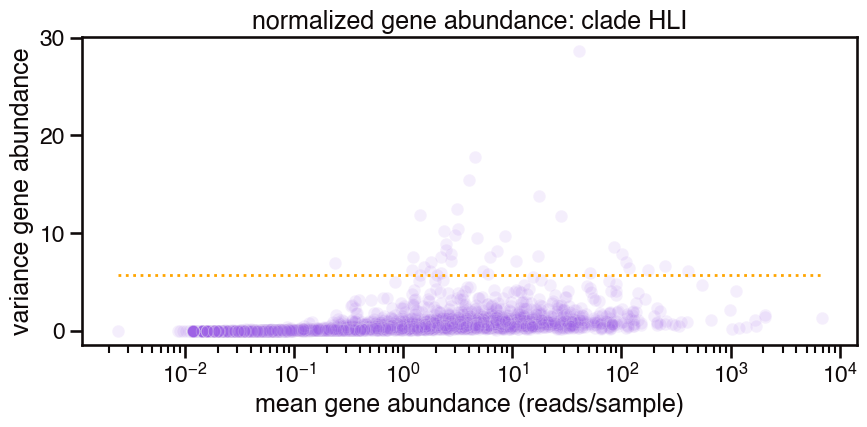

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3806

R[write to console]: Total overdispersed genes: 3600

R[write to console]: Excluding 206 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3806 by 137

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 3600 genes, 137 cells



HLII
  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 206

R[write to console]: Calling offset model for all 206 poisson genes

R[write to console]: Found 2 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 206 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  2.56

R[write to console]: Second step: Get residuals using fitted parameters for 3806 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.224081 secs



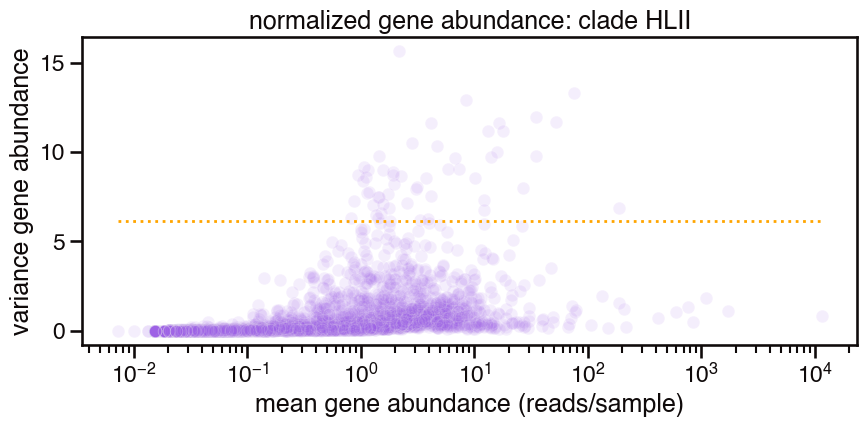

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2899

R[write to console]: Total overdispersed genes: 2818

R[write to console]: Excluding 81 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2899 by 129

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2818 genes, 129 cells



LLI
  |======================================================================| 100%


R[write to console]: Setting estimate of  5 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 5

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 81

R[write to console]: Calling offset model for all 81 poisson genes

R[write to console]: Found 7 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 81 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 2899 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.78413 secs



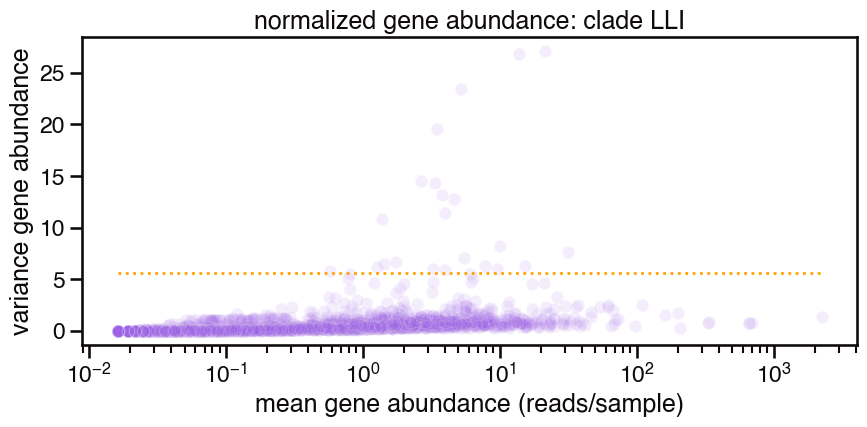

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2980

R[write to console]: Total overdispersed genes: 2876

R[write to console]: Excluding 104 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2980 by 202

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2876 genes, 202 cells



5.1A-I
  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 2

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 104

R[write to console]: Calling offset model for all 104 poisson genes

R[write to console]: Found 7 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 104 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 2980 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.855056 secs



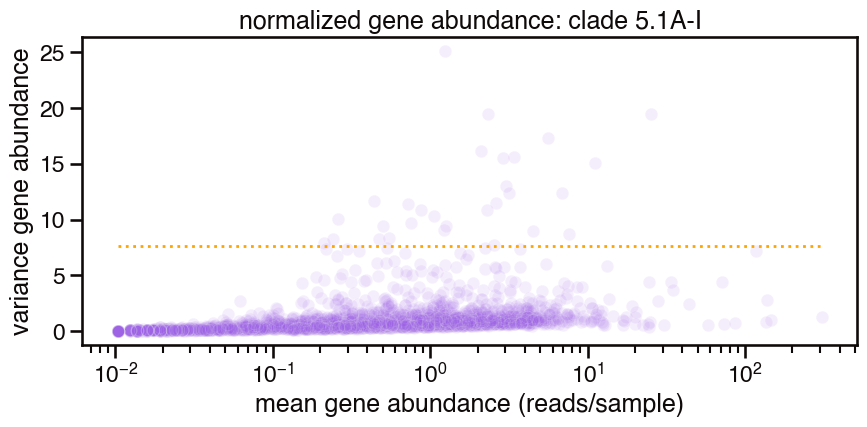

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3049

R[write to console]: Total overdispersed genes: 2982

R[write to console]: Excluding 67 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3049 by 130

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2982 genes, 130 cells



5.1A-II
  |======================================================================| 100%


R[write to console]: Setting estimate of  4 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 4

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 67

R[write to console]: Calling offset model for all 67 poisson genes

R[write to console]: Found 7 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 67 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 3049 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.859175 secs



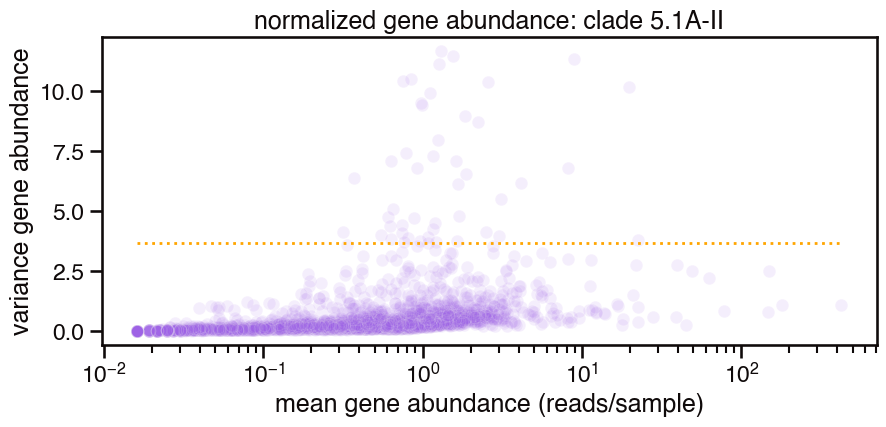

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2153

R[write to console]: Total overdispersed genes: 2062

R[write to console]: Excluding 91 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2153 by 123

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2062 genes, 123 cells



5.1A-III
  |======================================================================| 100%


R[write to console]: Setting estimate of  3 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 3

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 91

R[write to console]: Calling offset model for all 91 poisson genes

R[write to console]: Found 5 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 91 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 2153 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.290108 secs



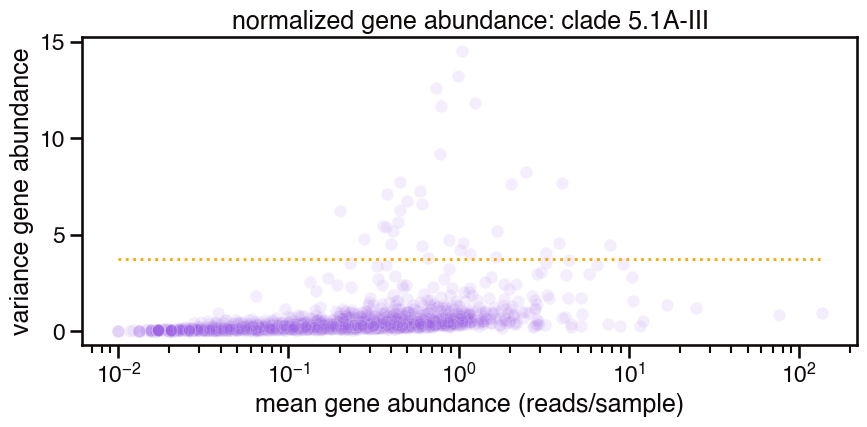

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3197

R[write to console]: Total overdispersed genes: 3133

R[write to console]: Excluding 64 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3197 by 207

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 3133 genes, 207 cells



5.1A-IV
  |======================================================================| 100%


R[write to console]: Setting estimate of  10 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 10

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 64

R[write to console]: Calling offset model for all 64 poisson genes

R[write to console]: Found 20 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 64 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 3197 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.087558 secs



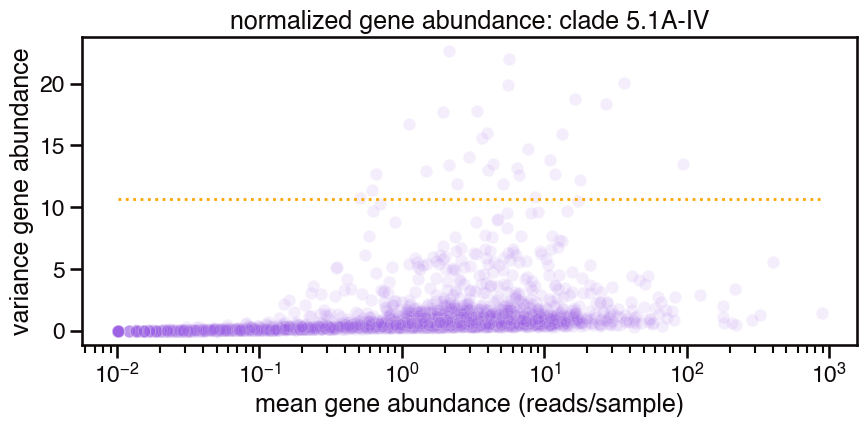

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3706

R[write to console]: Total overdispersed genes: 3603

R[write to console]: Excluding 103 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3706 by 151

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 3603 genes, 151 cells



5.1B-VII
  |======================================================================| 100%


R[write to console]: Setting estimate of  23 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 23

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 103

R[write to console]: Calling offset model for all 103 poisson genes

R[write to console]: Found 30 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 103 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 3706 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.332506 secs



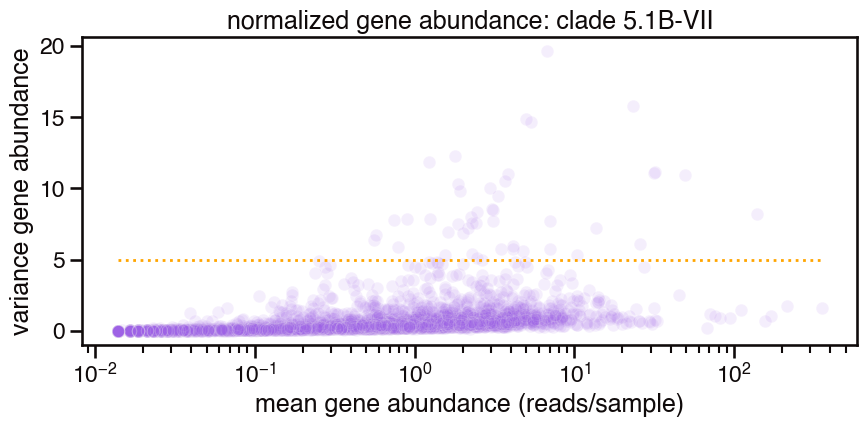

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3039

R[write to console]: Total overdispersed genes: 2955

R[write to console]: Excluding 84 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3039 by 143

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2955 genes, 143 cells



CDR2
  |======================================================================| 100%


R[write to console]: Setting estimate of  10 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 10

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 84

R[write to console]: Calling offset model for all 84 poisson genes

R[write to console]: Found 12 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 84 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 3039 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.961178 secs



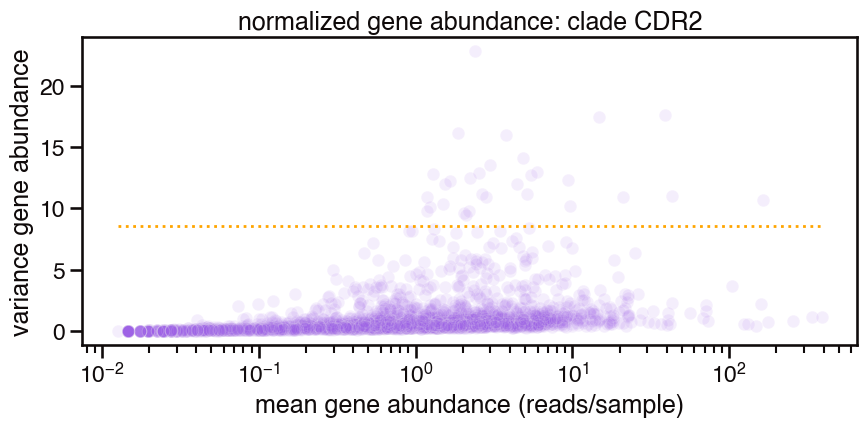

In [21]:
# run the model on each clade, saving outputs and plots

# iterate through clades
for i, clade in enumerate(clades):
    print(clade)
    
    # make fresh directory
    dir_path = '../../data/3-normalization/{}'.format(clade)
    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)
        
    # select clade_core_df
    clade_core_df = core_df_list[i]
    
    # convert to r matrix
    r_clade_core_df = pandas_dataframe_to_r_matrix(clade_core_df)
    
    # fit model
    result = sctransform.vst(r_clade_core_df, n_genes='null', min_cells=detection_min,
                             return_gene_attr=True, return_cell_attr=True, vst_flavor='v2', verbosity=10)

    # save residual
    residual_df = pd.DataFrame(np.asarray(result[0]), index=clade_core_df.index, columns=clade_core_df.columns)
    residual_df.to_csv('{}/residuals_{}.csv'.format(dir_path, clade))

    # save plot of model parameters
    plots = sctransform.plot_model_pars(result, show_theta=True)
    img = image_png(plots)
    with open('{}/parameters_{}.png'.format(dir_path, clade), 'wb') as png:
        png.write(img.data)
        
    # plot high variance genes
    residual_var = residual_df.var(axis=1)
    three_sigma = 1 + residual_var.var() * 3
    expression = clade_core_df.apply(geometric_mean, axis=1)
    plt.figure(figsize=(10, 4))
    sns.scatterplot(x=expression, y=residual_var, alpha=0.1);
    plt.hlines(three_sigma, expression.min(), expression.max(), 
               colors=['orange'], linestyles=[':'], label='3*sigma');
    plt.xlabel('mean gene abundance (reads/sample)')
    plt.xscale('log')
    plt.ylabel('variance gene abundance')
    plt.title('normalized gene abundance: clade {}'.format(clade))
    plt.savefig('{}/residual_variance_{}.png'.format(dir_path, clade))
    plt.show()
    
    # Save csv of residual variances with annotations
    res_var_df = residual_var.reset_index().rename(columns={0:'ResidualVariance'})
    res_var_df['Annotation'] = res_var_df.OrthologID.map(annotations_df.set_index('OrthologID')['Annotation'])
    res_var_df = res_var_df.sort_values('ResidualVariance', ascending=False).reset_index()
    res_var_df.to_csv('{}/high_variance_orthologs_{}.csv'.format(dir_path, clade))

    # Save plots of various orthologs
    orthologs = [60000001]
    orthologs.append(int(res_var_df.OrthologID[0]))
    for ortholog in orthologs:
        # Model plot
        plots = sctransform.plot_model(result, r_clade_core_df, ['{}'.format(ortholog)], 
                                       plot_residual=False, show_nr=False, arrange_vertical=False)
        img = image_png(plots)
        with open('{}/model_{}_{}.png'.format(dir_path, clade, ortholog), 'wb') as png:
            png.write(img.data)
#         # Plot of abundance vs sample clade abundance
#         fig, ax = plot_ortholog_reads(ortholog, clade, sample_summary_df, color_by='Dataset');
#         fig.savefig('{}/scatter_{}_{}.png'.format(dir_path, clade, ortholog))
#         plt.show()
        